In [3]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [4]:
!pip install opencv-python

In [5]:
import cv2

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as ans 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import tensorflow as tf
from tensorflow.keras import models, layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from keras.optimizers import Adam
import warnings
warnings.simplefilter ("ignore")
import os,cv2,json
from PIL import Image

In [8]:
WORK_DIR="/kaggle/input/cassava-leaf-disease-classification"
os.listdir (WORK_DIR)


['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [9]:
print('Train images: %d' %len (os.listdir ( os.path.join (WORK_DIR, "train_images"))))

Train images: 21397


In [10]:
with open(os.path.join (WORK_DIR, "label_num_to_disease_map.json")) as file : print (json.dumps (json. loads (file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [11]:
train_labels = pd.read_csv (os.path.join (WORK_DIR, "train.csv")) 
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [12]:
import seaborn as sns

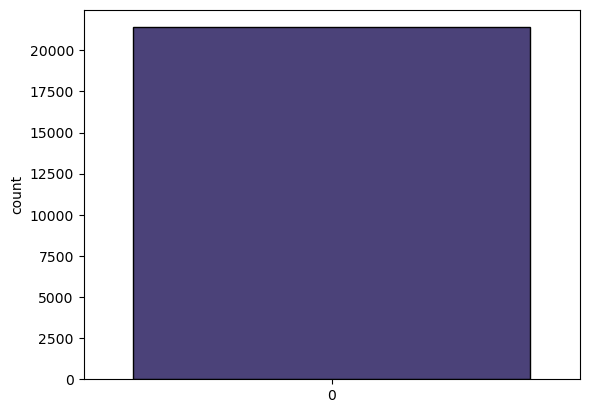

In [13]:
sns.countplot (train_labels.label, edgecolor = 'black',palette = sns.color_palette ("viridis", 5))

plt.show()

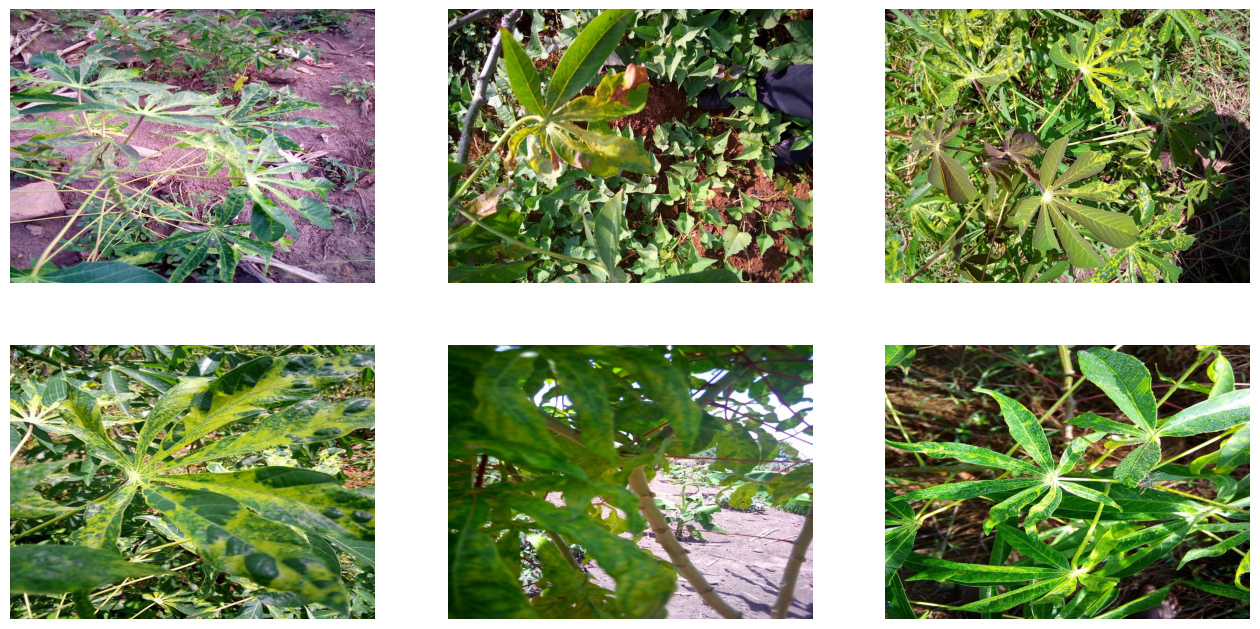

In [14]:

sample = train_labels [train_labels.label == 3].sample(6)

plt.figure(figsize=(16, 8)) 
for ind, (image_id, label) in enumerate (zip (sample.image_id,sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread (os.path.join (WORK_DIR, "train_images", image_id) )
    image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB) 
    plt.imshow(image)
    plt.axis ("off")

plt.show()

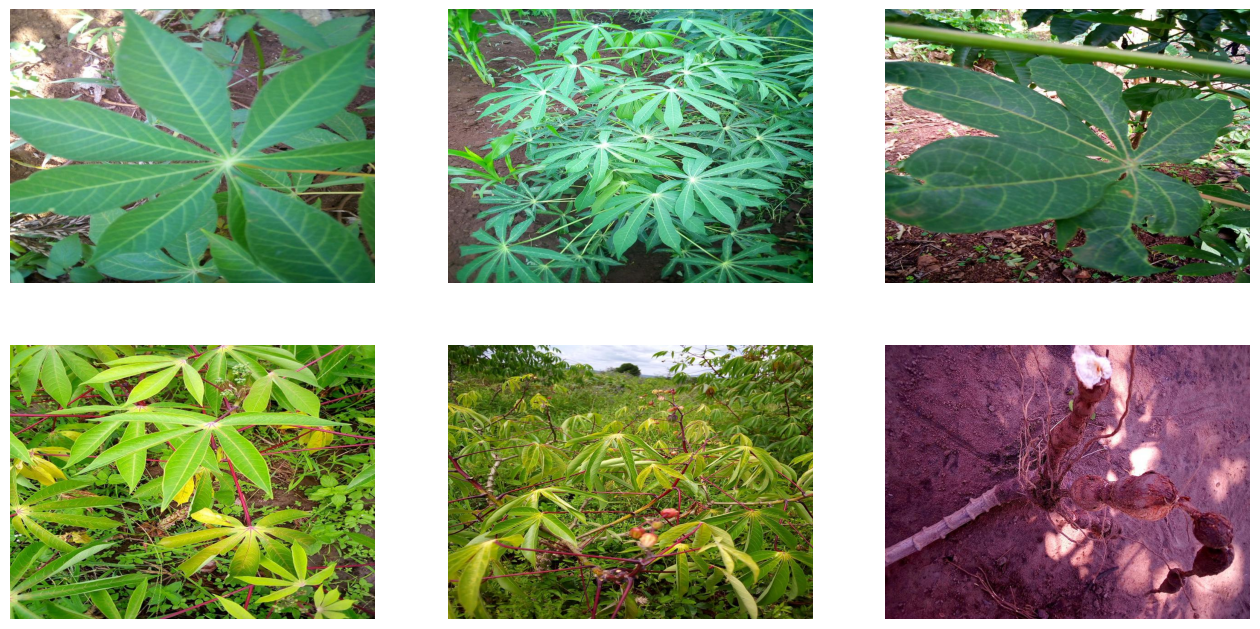

In [15]:
sample = train_labels [train_labels.label == 4].sample (6)

plt.figure(figsize=(16, 8)) 
for ind, (image_id, label) in enumerate (zip (sample.image_id, sample.label)):
    plt.subplot (2, 3, ind+ 1)
    image =cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image) 
    plt.axis ("off")

plt.show()

In [16]:
BATCH_SIZE= 16

STEPS_PER_EPOCH = len(train_labels) *0.8 / BATCH_SIZE
VALIDATION_STEPS= len(train_labels) *0.2 / BATCH_SIZE

EPOCHS= 20
TARGET_SIZE = 224
train_labels.label = train_labels.label.astype ('str')
train_generator = ImageDataGenerator (validation_split = 0.2,
                                      preprocessing_function = None,
                                      zoom_range= 0.2,
                                      cval = 0.2,
                                      horizontal_flip = True,
                                      vertical_flip = True,
                                      fill_mode='nearest',
                                      shear_range= 0.2,
                                      height_shift_range = 0.2,
                                      width_shift_range = 0.2) \
.flow_from_dataframe (train_labels,
                          directory=os.path.join(WORK_DIR, "train_images"),
                          subset = "training",
                          x_col = "image_id",
                          y_col = "label",
                          target_size = (TARGET_SIZE, TARGET_SIZE),
                          batch_size = BATCH_SIZE,
                          class_mode = "sparse")
validation_generator = ImageDataGenerator (validation_split = 0.2)\
.flow_from_dataframe (train_labels,
                      directory = os.path.join(WORK_DIR, "train_images"),
                      subset = "validation",
                      x_col = "image_id",
                      y_col = "label",
                      target_size = (TARGET_SIZE, TARGET_SIZE),
                      batch_size = BATCH_SIZE,
                      class_mode = "sparse")

def create_model():
    model = models. Sequential()
    model.add(EfficientNetB0 (include_top= False, weights = 'imagenet', input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense (5, activation ="softmax"))
    model.compile (optimizer = Adam (lr = 0.001),
                   loss="sparse_categorical_crossentropy",
                   metrics =["acc"])
    return model
model=create_model()
model.summary()

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


Epoch 1/20
1070/1069 [==============================] - ETA: 0s - loss: 0.7114 - acc: 0.7430
Epoch 1: val_loss improved from inf to 0.93371, saving model to ./best_baseline_model.h5
1069/1069 [==============================] - 393s 367ms/step - loss: 0.7114 - acc: 0.7430 - val_loss: 0.9337 - val_acc: 0.6700 - lr: 0.0010
Epoch 2/20
1070/1069 [==============================] - ETA: 0s - loss: 0.5833 - acc: 0.7952
Epoch 2: val_loss improved from 0.93371 to 0.53861, saving model to ./best_baseline_model.h5
1069/1069 [==============================] - 295s 276ms/step - loss: 0.5833 - acc: 0.7952 - val_loss: 0.5386 - val_acc: 0.8149 - lr: 0.0010
Epoch 3/20
1070/1069 [==============================] - ETA: 0s - loss: 0.5410 - acc: 0.8094
Epoch 3: val_loss did not improve from 0.53861
1069/1069 [==============================] - 294s 275ms/step - loss: 0.5410 - acc: 0.8094 - val_loss: 0.6029 - val_acc: 0.7712 - lr: 0.0010
Epoch 4/20
1070/1069 [==============================] - ETA: 0s - loss: 

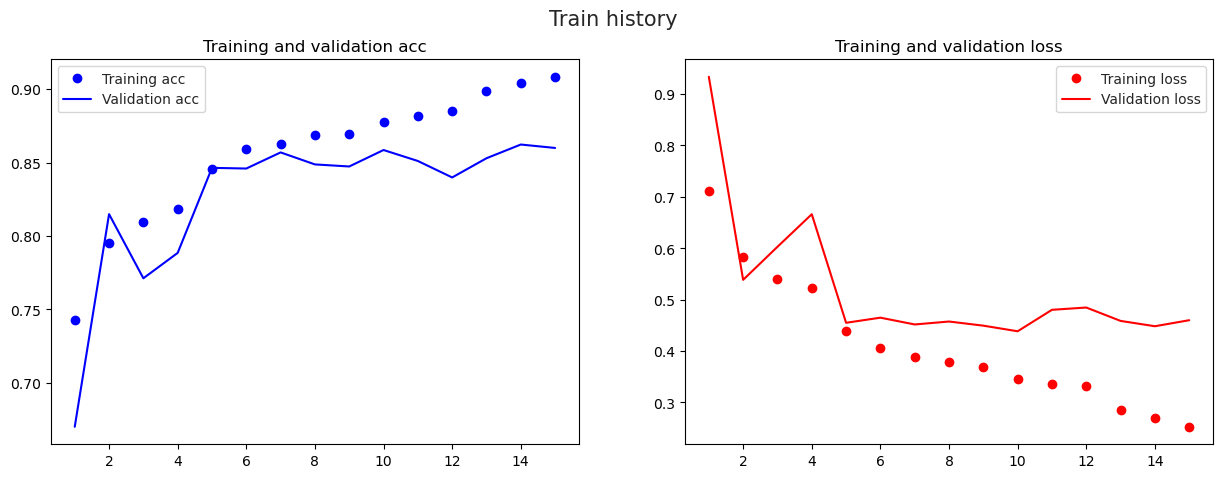

In [18]:
model_save = ModelCheckpoint ('./best_baseline_model.h5',
                              save_best_only = True,
                              save_weights_only = True,
                              monitor = 'val_loss',
                              mode = 'min', verbose = 1)

early_stop = EarlyStopping (monitor = 'val_loss', min_delta = 0.001,
                            patience = 5, mode = 'min', verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau (monitor = 'val_loss', factor = 0.3,
                               patience=2, min_delta = 0.001,
                               mode='min', verbose = 1)

history = model.fit_generator (train_generator,
                               steps_per_epoch=STEPS_PER_EPOCH, 
                               epochs=EPOCHS, 
                               validation_data=validation_generator,
                               validation_steps= VALIDATION_STEPS,
                               callbacks =[model_save, early_stop, reduce_lr])

acc =history.history['acc'] 
val_acc=history.history['val_acc'] 
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs= range (1, len (acc) + 1)

fig, (axl, ax2) =plt.subplots(1, 2, figsize=(15, 5)) 
sns.set_style("white") 
plt.suptitle('Train history', size = 15)
 
axl.plot (epochs, acc, "bo", label = "Training acc")
axl.plot (epochs, val_acc, "b", label = "Validation acc") 
axl.set_title("Training and validation acc") 
axl.legend()
             
ax2.plot (epochs, loss, "bo", label ="Training loss", color ='red') 
ax2.plot (epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()
             
plt.show()

In [19]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

from tensorflow.keras import models, layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from keras.optimizers import Adam

#ignoring warnings
import warnings
warnings.simplefilter("ignore")
import os, cv2, json
from PIL import Image

TARGET_SIZE=224

def create_model():
    model= models.Sequential()
    model.add(EfficientNetB0(include_top=False, weights=None, input_shape =(TARGET_SIZE, TARGET_SIZE, 3)))
    model.add(layers. GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))
    model.compile(optimizer= Adam(lr=0.001), loss="sparse_categorical_crossentropy",metrics = ["acc"])
    return model

model=create_model() 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [20]:
model.load_weights(r"/kaggle/working/best_baseline_model.h5")

In [21]:
image =Image.open("/kaggle/input/cassava-leaf-disease-classification/test_images/2216849948.jpg")
image =image.resize((TARGET_SIZE, TARGET_SIZE)) 
image= np.expand_dims(image, axis= 0) 
pred= np.argmax(model.predict(image)) 
print(model.predict(image))

labels={
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}

1/1 [==============================] - 0s 24ms/step
[[0.00493943 0.00181595 0.16791682 0.00396896 0.82135886]]


In [22]:
print(labels[str(pred)])

Healthy
